# Direct Wish et al., 1976 Replication

## Data preparation and cleaning

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#from matplotlib.collections import LineCollection
from sklearn import manifold, preprocessing
#from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

from scipy import stats

Total number of responses from qualtrics - 721


No handles with labels found to put in legend.


Number of cells containing data - 25
maximum number of subjects rating - 127
minimum number of subjects rating - 80
Total number of responses, excluding bad participants - 592


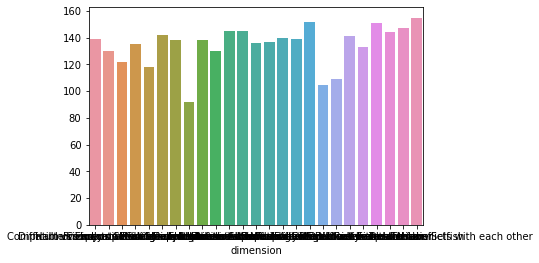

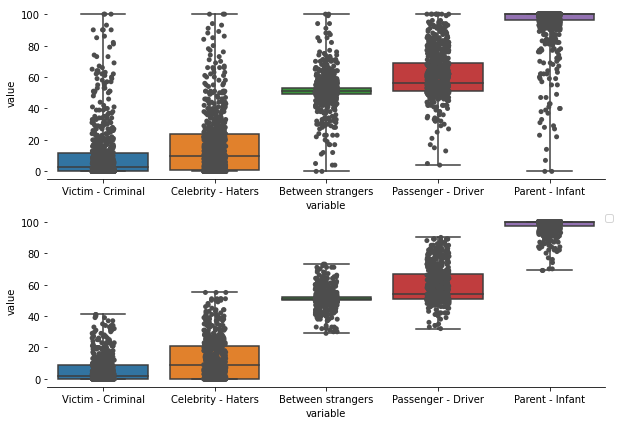

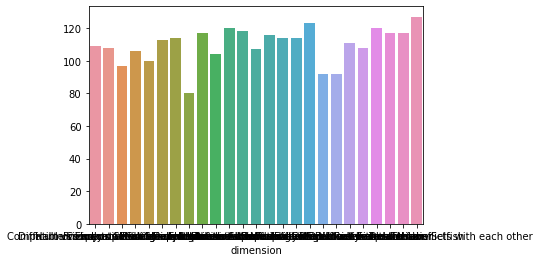

In [3]:
# Prep responses and key
raw = pd.read_csv('input_data/wish_replication/RK - Wish Replication - Version 1_March 15, 2019_12.49.csv')
raw_reorg = raw.drop(axis='index',index=[0,1])
raw_reorg['subject'] = list(raw_reorg.index)
raw_reorg = raw_reorg.reset_index(drop=True)
raw_reorg['Duration (in seconds)'] = pd.to_numeric(raw_reorg['Duration (in seconds)'])
key = pd.read_csv('input_data/wish_replication/qualtrics_question_key.csv')

responses = raw_reorg
responses['subject'] = list(raw_reorg.index)
responses = responses.loc[:, responses.columns.str.startswith('Q')]
responses = responses[responses.columns[1:-7]]

# Get total number of responses
print("Total number of responses from qualtrics - "+str(len(responses)))

relationships = [x for x in raw.iloc[0].tolist() if x.startswith('Q8.1')]
relationships = [s.replace('\xe2\x80\x93', '-') for s in relationships]
relationships = [x[7:] for x in relationships]
dimension_frames = {}
count=0
for dim in key['dimension'].tolist()[:-2]:  # exclude foil and demographics
    filtered_cols = [col for col in raw_reorg if col.startswith('Q'+str(key['block'].iloc[count])+'.1')]
    dimension_frames[dim] = pd.DataFrame(responses[filtered_cols])
    dimension_frames[dim].columns = relationships
    # Delete all data for "between cousins" and only keep "second cousins"
    dimension_frames[dim]['Between second cousins'].iloc[:629] = np.nan
    count=count+1
  
num_response = []
for col in dimension_frames['Active vs Inactive'].columns:
    num_response.append(dimension_frames['Active vs Inactive'][col].count())
plt.figure()
sns.barplot(x=key['dimension'].iloc[:25],y=num_response)


# Check foils to see if any subjs responded indiscriminately
foil_relationships = [x for x in raw.iloc[0].tolist() if x.startswith('Q37')]
foil_relationships = [x[6:] for x in foil_relationships]
filtered_cols = [col for col in raw_reorg if col.startswith('Q37')]
foils = pd.DataFrame(responses[filtered_cols])
foils.columns = foil_relationships
foils['MTurkCode']  =raw_reorg['MTurkCode']
foils = foils.apply(pd.to_numeric)
foils_melt = pd.melt(foils, id_vars='MTurkCode')

# Check for values above means for unexpected foils
outliers_list = []
for rel in foils.columns[:-1]:
    outliers_list = outliers_list + list(foils[(foils[rel] > 
                   foils[rel].mean()+foils[rel].std()*2) |
                   (foils[rel] < 
                    foils[rel].mean()-foils[rel].std()*2)].index)
outliers_list = set(outliers_list)



# Remove outliers based on assumptions of words
# Frequency of deathbed > car
# Removing subjects based on completetion time is not the best (they do okay)
foil_outliers = foils
foil_outliers = foil_outliers[~foil_outliers.index.isin(outliers_list)]
foil_outliers_melt = pd.melt(foil_outliers, id_vars='MTurkCode')


f, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=False)
sns.despine(left=True)
sns.stripplot(x="variable", y="value", data=foils_melt, 
              color='.3', jitter=True, ax=axes[0])
sns.stripplot(x="variable", y="value", data=foil_outliers_melt, 
              color='.3', jitter=True,  ax=axes[1])
sns.boxplot(x="variable", y="value", data=foils_melt, whis=np.inf, ax=axes[0])
sns.boxplot(x="variable", y="value", data=foil_outliers_melt, whis=np.inf, ax=axes[1])
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)


# Remove outliers from the rest of the data
dimension_frames_outliers = dimension_frames.copy()
for dim in dimension_frames_outliers:
    dimension_frames_outliers[dim] = dimension_frames[dim][~dimension_frames[dim].index.isin(outliers_list)]
    dimension_frames_outliers[dim] = dimension_frames_outliers[dim].apply(pd.to_numeric)
    
    
# Check total number of responses for each word with outliers excluded
num_response = []
for col in dimension_frames_outliers['Active vs Inactive'].columns:
    num_response.append(dimension_frames_outliers['Active vs Inactive'][col].count())
plt.figure()
sns.barplot(x=key['dimension'].iloc[:25],y=num_response)

#print("Total number of responses, excluding bad participants - "+str(len(dimension_frames_outliers['Active vs Inactive'])))




dimensions = key['dimension'].iloc[:25]
dimensions = dimensions.to_list()

num_response_afterDK_count =  pd.DataFrame(columns=relationships)
count = 0
for dim in dimensions: 
    num_response_afterDK_count.loc[count] = [dimension_frames_outliers[dim][col].count() for col in dimension_frames_outliers[dim].columns]
    count += 1 
num_response_afterDK_count.index = dimensions

print("Number of cells containing data - " + str(num_response_afterDK_count.isnull().all().count())) 

print("maximum number of subjects rating - " + str(max(list(num_response_afterDK_count.max()))))
print("minimum number of subjects rating - " + str(min(list(num_response_afterDK_count.min()))))

print("Total number of responses, excluding bad participants - "+str(len(dimension_frames_outliers[dim])))

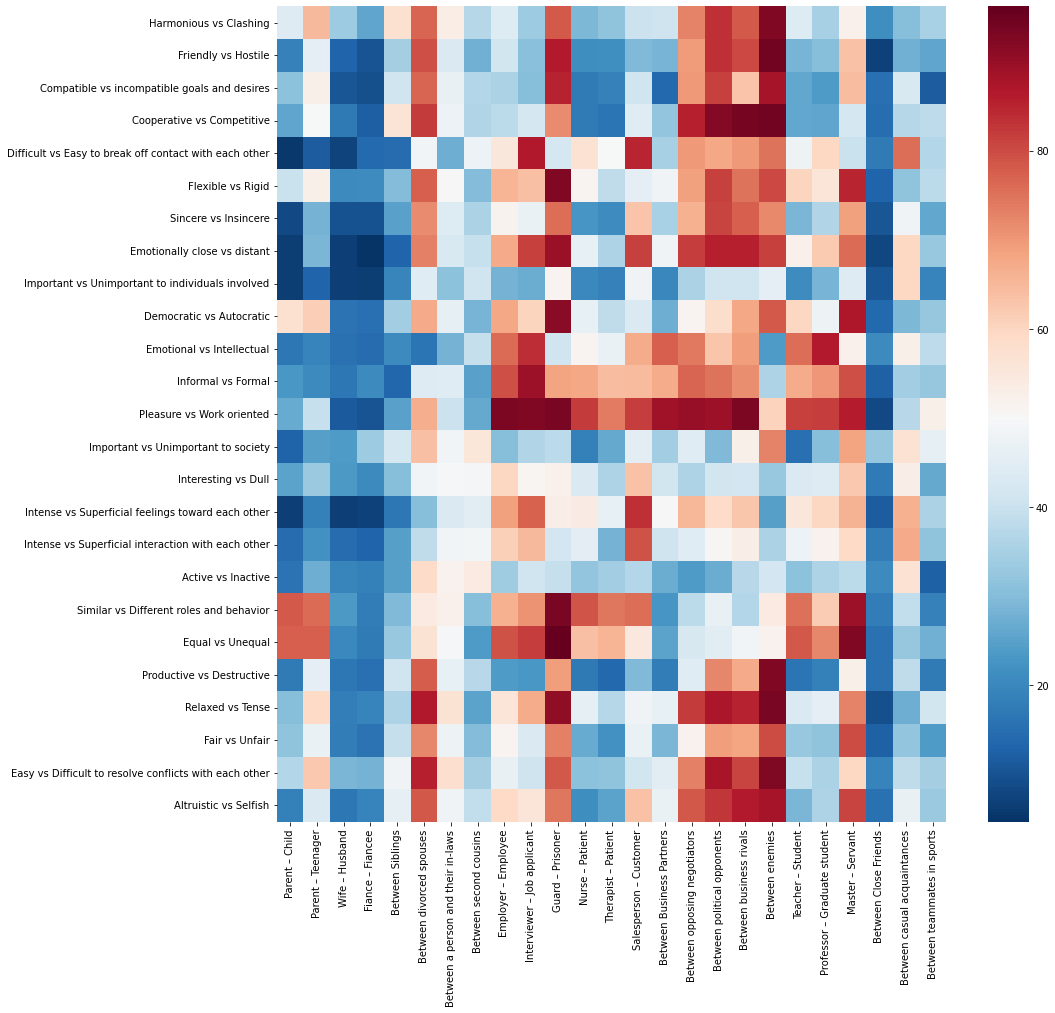

In [4]:
# Create a dataframe that has the average response for each relationship, on each dimension
dim_rel = pd.DataFrame(columns=relationships)
count=0
for dim in dimension_frames_outliers.keys():
    dim_rel.loc[count] = dimension_frames_outliers[dim].mean().tolist()
    count = count + 1
dim_rel.index = dimension_frames_outliers.keys()
dim_rel.to_csv('output_data/wish_replication/dim_rel.csv')


plt.figure(figsize=(15,15))
heatmap = sns.heatmap(dim_rel, center=50,cmap="RdBu_r")
fig = heatmap.get_figure()
fig.savefig('output_data/wish_replication/dim_rel_heatmap.png')

# Scale the matrix. This is typically in PCA so that the dimensions are normed.
dim_rel_scaled = preprocessing.scale(dim_rel.transpose())
dim_rel_scaled_df = pd.DataFrame(dim_rel_scaled, index=dim_rel.columns,
                                 columns=dim_rel.index)

dim_rel_scaled_df
dim_rel_scaled_df.to_csv('output_data/wish_replication/dim_rel_scaled.csv')

# Quantitatively selecting the number of components

In [2]:
library(tidyverse)
library(reshape)

library(psych)
#optimal number of components
library(nFactors)

library(ggplot2)
library(pheatmap)
library(RColorBrewer)
library(corrplot)

In [3]:
plotnScree <-
function (nScree,
          elbow = 3,
          legend = TRUE,
          ylab   = "Eigenvalues",
          xlab   = "Components",
          main   = "Non Graphical Solutions to Scree Test")
          {
   if (!inherits(nScree, "nScree"))  stop("Method is only for nScree objects")
   #if (!exists("legend", mode="logical") ) legend <- TRUE                                   # To develop
   #if (!exists("ylab"))                    ylab <- "Eigenvalues"                            # To develop
   #if (!exists("xlab"))                    xlab <- "Components"                             # To develop
   #if (!exists("main"))                    main <- "Non Graphical Solutions to Scree Test"  # To develop
   if (nScree$Model == "components") nkaiser = "Eigenvalues (>mean  = " else nkaiser = "Eigenvalues (>0 = "
   if (nScree$Model == "factors")  xlab   = "Factors"
   par(col   = 1, pch = 1)     # Color and symbol for usual scree
   par(mfrow = c(1,1),lwd=2)
   eig        <- nScree$Analysis$Eigenvalues
   k          <- 1:length(eig)
   #plotuScree(x=eig, ...)                                                                   # To develop
   plotuScree(x=eig, main=main, xlab=xlab, ylab=ylab)
   nk         <- length(eig)
   noc        <- nScree$Components$noc
   vp.p       <- lm(eig[c(noc+1,nk)] ~ k[c(noc+1,nk)])
   x          <- sum(c(1,1) * coef(vp.p))
   y          <- sum(c(1,nk)* coef(vp.p))
   par(col = 10)            # Color for optimal coordinates
   lines(k[c(1,nk)],c(x,y),lwd=1.8)
   par(col = 11,pch=2)            # Color and symbol for parallel analysis
   lines(1:nk, nScree$Analysis$Par.Analysis, type = "b",lwd=1.8)
   if (legend == TRUE) {
     leg.txt  <- c(paste("Parallel Analysis (n = ",nScree$Components$nparallel,")"),
                 c(paste("Kaiser-Guttman rule (n = ",nScree$Components$nkaiser,")")),
                 c(paste("Cattell’s scree test (n = ",elbow,")")),
                 c(paste("Optimal Coordinates (n = ",nScree$Components$noc,")")) )
     legend("topright",
            legend   = leg.txt,
            pch      = c('△','_','○','_'),
            text.col = c(3,4,1,2), 
            col = c(3,4,1,2),
            cex = 1.3)
     }
   naf        <-   nScree$Components$naf
   text(x = noc ,    y = eig[noc],     label = " (OC)", cex = 1, adj = c(0,0), col = 2)
#    text(x = naf + 1, y = eig[naf + 1], label = " (AF)", cex = .70, adj = c(0,0), col = 4)
   }

In [4]:
# import relationship dimension ratings scaled from the Data cleaning's output
dim_rel_scaled = read.csv('output_data/wish_replication/dim_rel_scaled.csv', 
                          row.names=1,encoding='UTF-8',check.names=FALSE)

In [5]:
options(repr.plot.width=8, repr.plot.height=8)
# Parallel analysis, Optimal Coordinates, and  Cattell's Scree Test
ev <- eigen(cor(dim_rel_scaled)) # get eigenvalues
ap <- parallel(subject=nrow(dim_rel_scaled),var=ncol(dim_rel_scaled),model="components",rep=5000,cent=.05) 
nS <- nScree(x=ev$values, aparallel=ap$eigen$qevpea) # "qevpea" indicate 95 centile given cent=.05

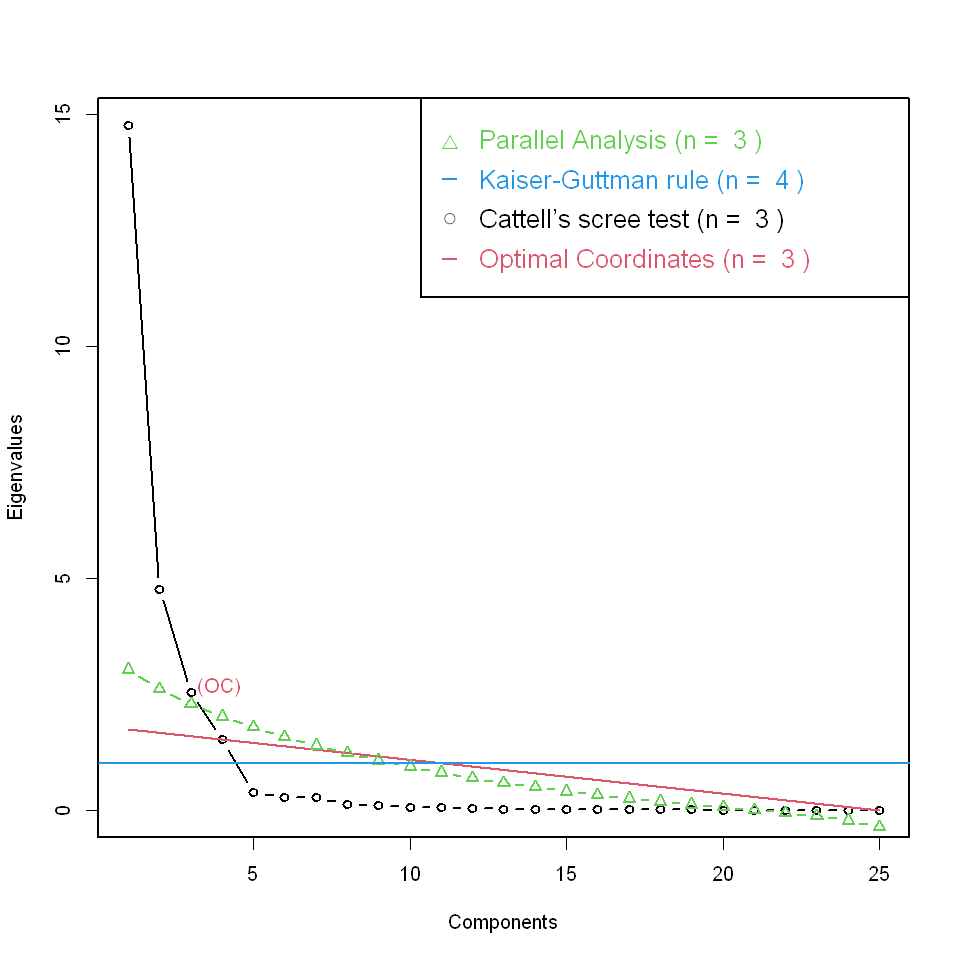

In [6]:
plotnScree(nS,elbow = 3, legend=TRUE, main = NULL)
abline(h = 1, col=4, lty=1,lwd =1.8) # Kaiser-Guttman Rule

## 4d solution

In [7]:
dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 4

loadings_none = dim_rel.pca$rotation[,1:ncomp]
scores_none = dim_rel.pca$x[,1:ncomp] 

rawLoadings = loadings_none %*% diag(dim_rel.pca$sdev,ncomp,ncomp)
loadings_var = varimax(rawLoadings)$loadings
scores_var = scale(scores_none) %*% varimax(rawLoadings)$rotmat

write.csv(loadings_var,'output_data/pca_results/wish_replication/loadings_var_4c.csv')
scores_var = as.data.frame(scores_var)
write.csv(scores_var,'output_data/pca_results/wish_replication/scores_var_4c.csv')

### loading score

In [8]:
loadings_var


Loadings:
                                                       [,1]   [,2]   [,3]  
Harmonious vs Clashing                                  0.996         0.104
Friendly vs Hostile                                     0.983  0.157  0.140
Compatible vs incompatible goals and desires            0.931         0.194
Cooperative vs Competitive                              0.973  0.154 -0.106
Difficult vs Easy to break off contact with each other  0.265  0.807       
Flexible vs Rigid                                       0.777  0.425  0.471
Sincere vs Insincere                                    0.809  0.473       
Emotionally close vs distant                            0.612  0.714  0.197
Important vs Unimportant to individuals involved        0.521  0.406       
Democratic vs Autocratic                                0.676  0.222  0.697
Emotional vs Intellectual                                      0.985       
Informal vs Formal                                      0.207  0.900  0.358
P

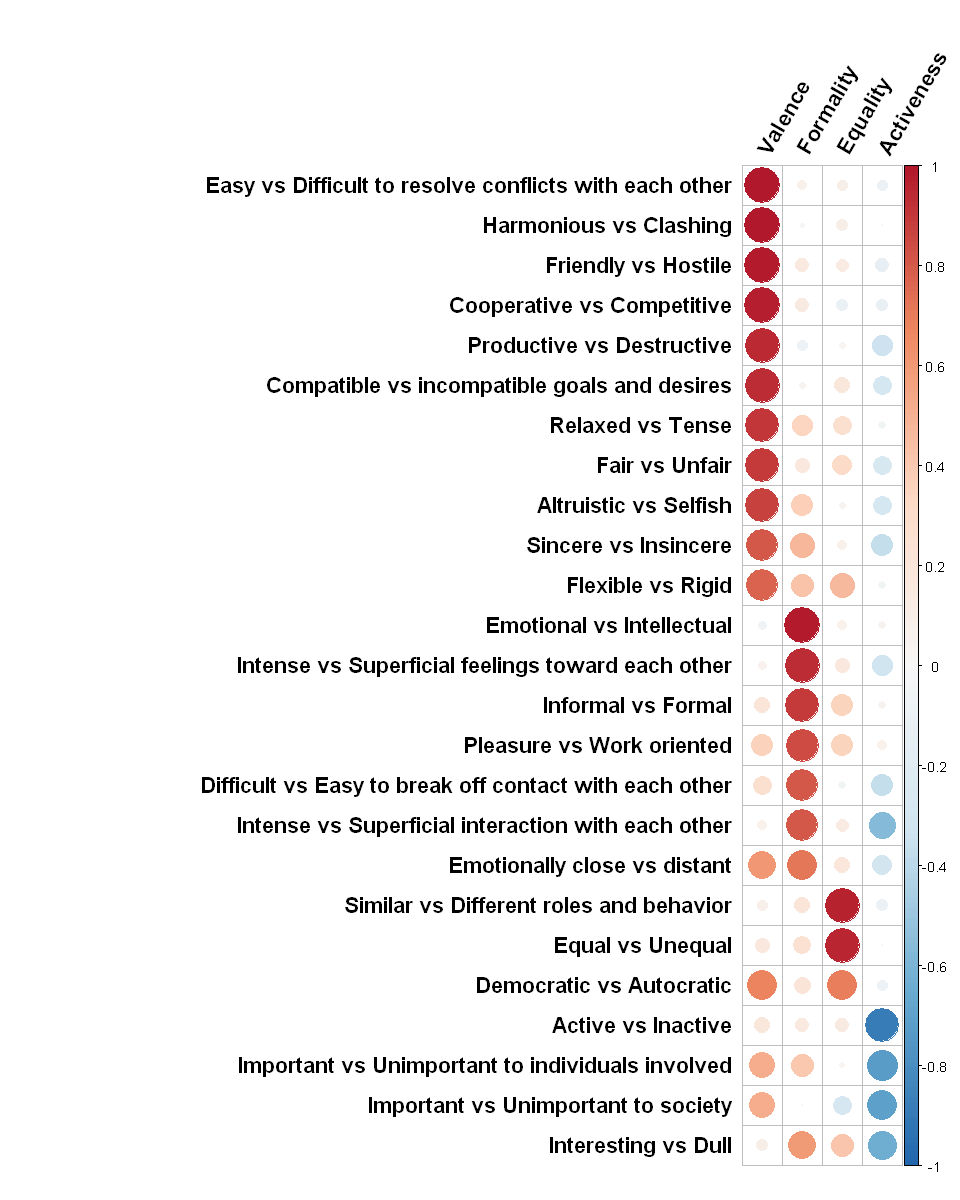

In [9]:
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:25)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:4)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
loadings_var_reorder['rel'] = rownames(loadings_var_reorder)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(V1))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(V2))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(V3))
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(V4)
rownames(loadings_var_reorder) = loadings_var_reorder$'rel'

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4)
loadings_var_reorder = loadings_var_reorder[1:4]

colnames(loadings_var_reorder) = c('Valence','Formality','Equality','Activeness')
options(repr.plot.width=8, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.4,cl.cex=0.7,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

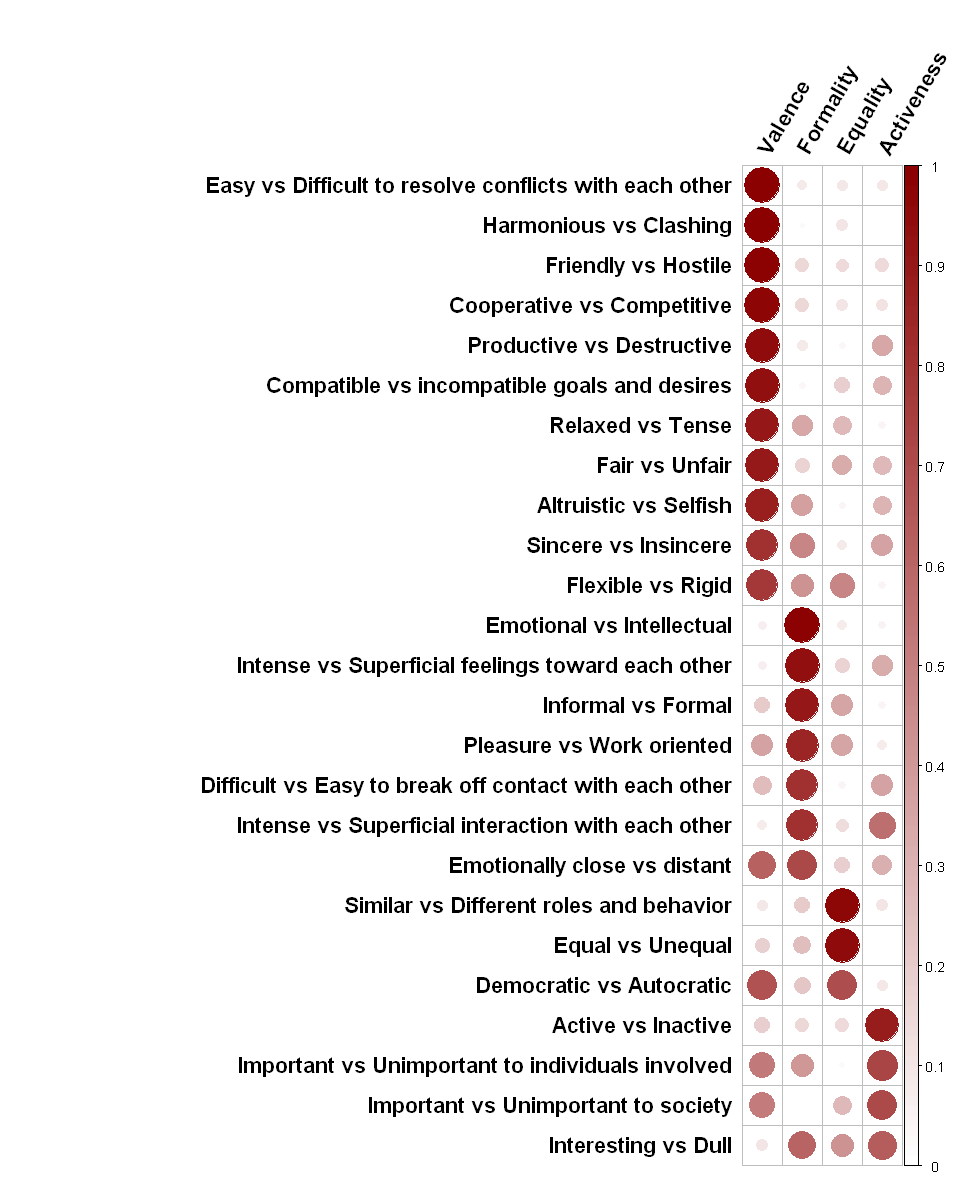

In [12]:
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:25)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:4)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = abs(loadings_var_reorder) %>% mutate(order = order_list)
loadings_var_reorder['rel'] = rownames(loadings_var_reorder)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(V1))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(V2))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(V3))
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(V4))
rownames(loadings_var_reorder) = loadings_var_reorder$'rel'

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4)
loadings_var_reorder = loadings_var_reorder[1:4]

colnames(loadings_var_reorder) = c('Valence','Formality','Equality','Activeness')
options(repr.plot.width=8, repr.plot.height=10)
my.breaks = c(seq(0,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(0,1),cl.ratio = 0.4,cl.cex=0.7,
         col= colorRampPalette(c("white","darkred"))(100))

### relationship score

In [14]:
library(RColorBrewer)
library(corrplot)

library(ggplot2)
library(tidyverse)
library(ggrepel)
library(Hmisc)

In [15]:
scores_var_plot = scores_var
colnames(scores_var_plot) = c('Valence','Formality','Equality','Activeness')
scores_var_plot['Valence'] = -scores_var_plot['Valence']
scores_var_plot['Equality'] = -scores_var_plot['Equality']

In [16]:
rels = rownames(scores_var_plot)
rels = gsub('Between ','',rels)
rels = gsub(' – ','-',rels,fixed=TRUE)
rels = capitalize(rels)
rownames(scores_var_plot) = rels
rels

[1] "Parent-Child"               "Parent-Teenager"           
 [3] "Wife-Husband"               "Fiance-Fiancee"            
 [5] "Siblings"                   "Divorced spouses"          
 [7] "A person and their in-laws" "Second cousins"            
 [9] "Employer-Employee"          "Interviewer-Job applicant" 
[11] "Guard-Prisoner"             "Nurse-Patient"             
[13] "Therapist-Patient"          "Salesperson-Customer"      
[15] "Business Partners"          "Opposing negotiators"      
[17] "Political opponents"        "Business rivals"           
[19] "Enemies"                    "Teacher-Student"           
[21] "Professor-Graduate student" "Master-Servant"            
[23] "Close Friends"              "Casual acquaintances"      
[25] "Teammates in sports"

In [17]:
scores_var_plot['rel'] =  rownames(scores_var_plot)
head(scores_var_plot)

,Valence,Formality,Equality,Activeness,rel
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Parent-Child,0.5285565,-1.5756292,-1.4849907,1.1829732,Parent-Child
Parent-Teenager,-0.4058238,-1.4800847,-1.2593009,0.6836730,Parent-Teenager
Wife-Husband,0.7836493,-1.2188952,0.8060696,0.7660283,Wife-Husband
Fiance-Fiancee,0.8182858,-1.1535730,1.0460411,0.6812589,Fiance-Fiancee
Siblings,-0.1799144,-1.2632549,0.7340960,0.2175561,Siblings
Divorced spouses,-1.4552157,-0.9089811,-0.2059736,-1.2804448,Divorced spouses


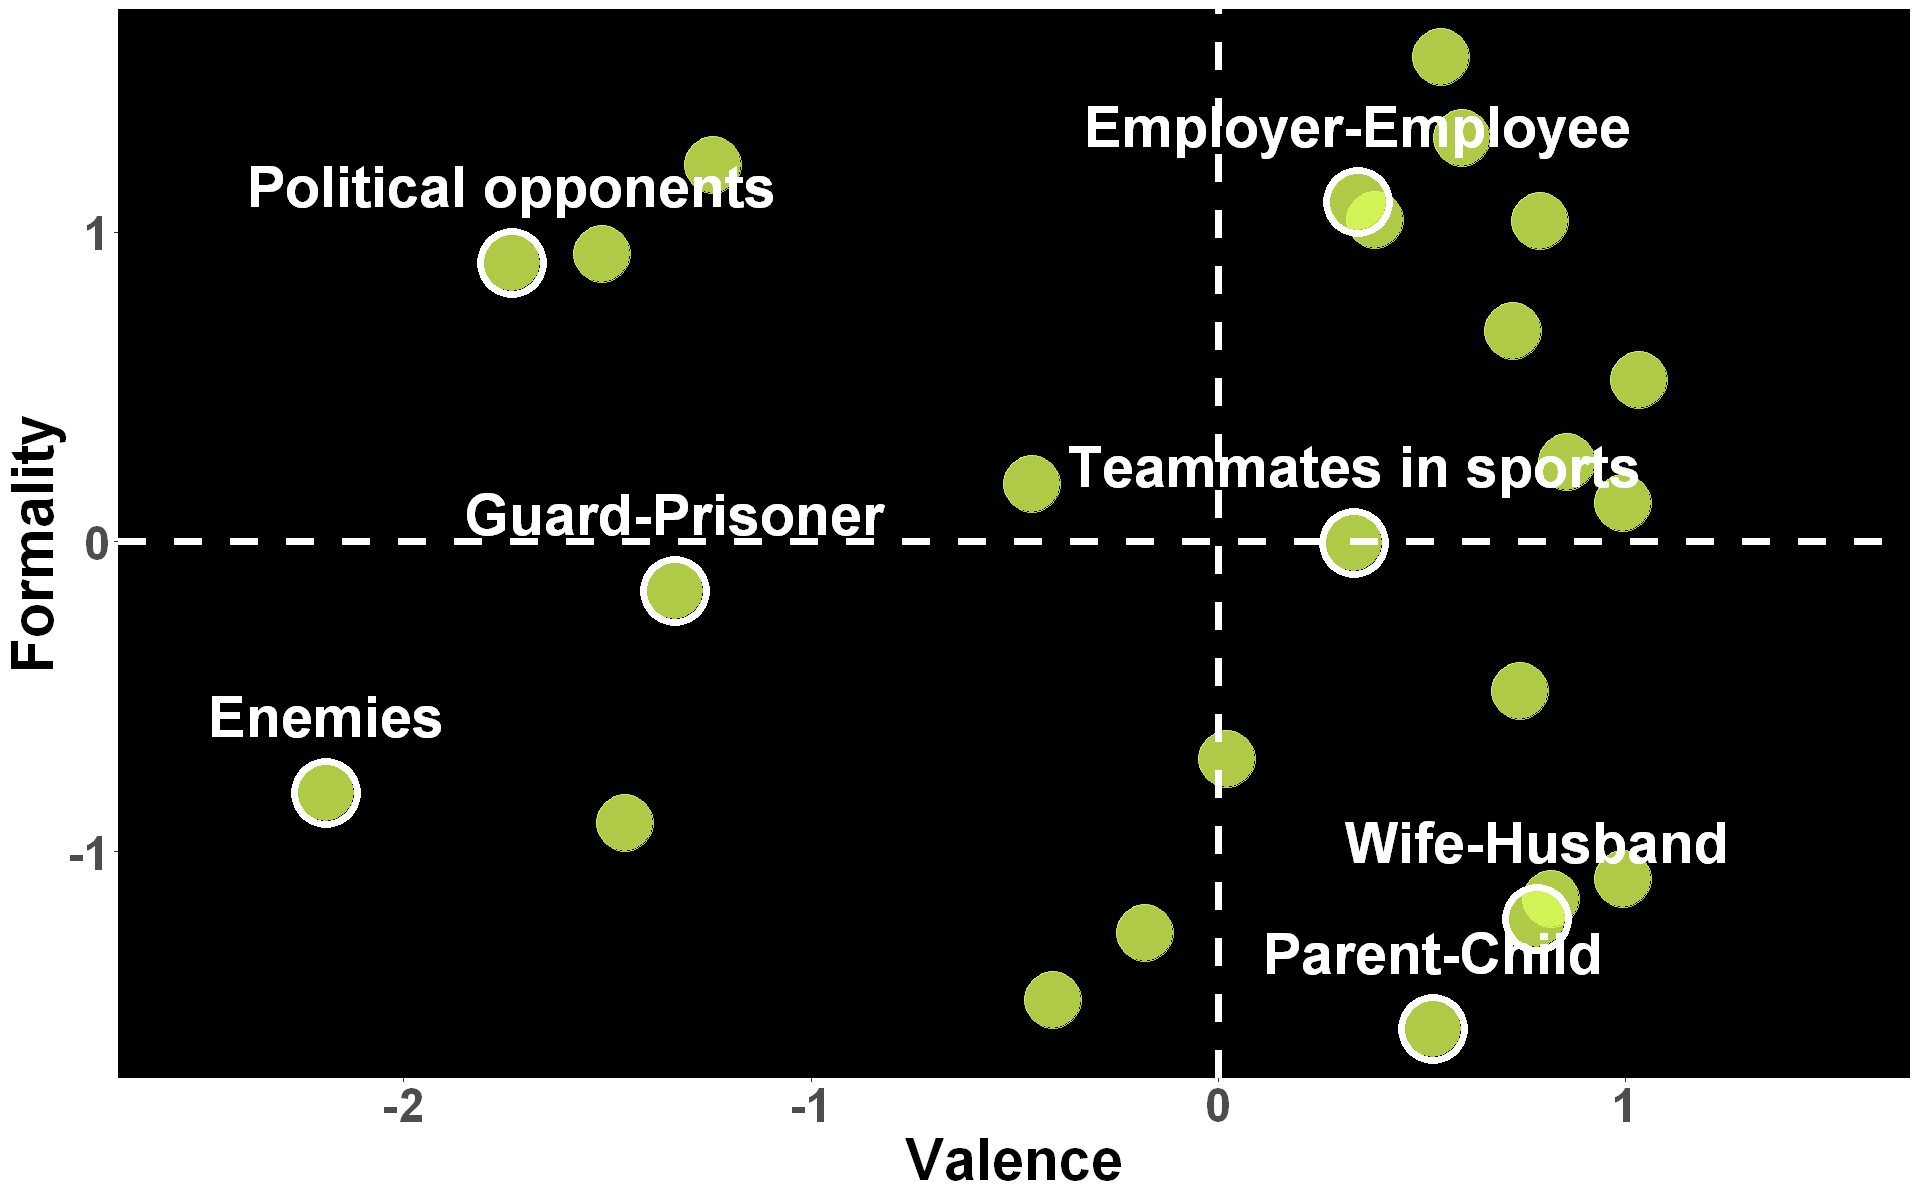

In [19]:
randomseed = 2022

rels_shown = c('Parent-Child','Wife-Husband','Employer-Employee','Guard-Prisoner','Enemies',
              'Political opponents','Teammates in sports')
rels_shown_plot = scores_var_plot %>% filter(rel%in%rels_shown)
# png("output_graph/study1/study1_scatter_FA_label.png", bg="transparent",
#      family = 'sans',units='in',width=16,height=10,res=300)
options(repr.plot.height=10,repr.plot.width=16)
ggplot(scores_var_plot, aes(x=Valence,y=Formality))+
geom_point(color='#DAFD59',size=16,alpha=0.8)+

#scale_color_gradient(low = 'white',high = '#DAFD59')+
#guides(alpha=guide_legend(title = 'alpha:RC5:Equality(7.4%)'))+

geom_text_repel(data = rels_shown_plot,
                mapping=aes(label=rownames(rels_shown_plot)),size=12,
                seed = randomseed,nudge_y=0.25,
                fontface = 'bold',color='white',
                #family='',
                min.segment.length = Inf)+
geom_point(data = rels_shown_plot,color='white',size=16,shape=1,stroke=3)+
# scale_size_continuous(range=c(0.1,12))+
#geom_rug(aes(color=Equality),color='#DAFD59')+

xlim(-2.5,1.5)+
xlab('Valence')+
ylab('Formality')+

geom_hline(yintercept = 0,linetype='dashed',size = 2,color='white')+
geom_vline(xintercept = 0,linetype='dashed',size = 2,color='white')+
#ggtitle('USA_Study3')+
theme_bw()+
theme(panel.border=element_blank(),panel.grid=element_blank(),
      panel.background = element_rect(fill = 'black'), 
      axis.title=element_text(size=35,face='bold'),
      axis.text=element_text(size=28,face='bold'),
      legend.title=element_text(face="bold",size=30),
      legend.position='top',#legend.key.height=unit(1,'cm')
      legend.text=element_text(face="bold",size=20))

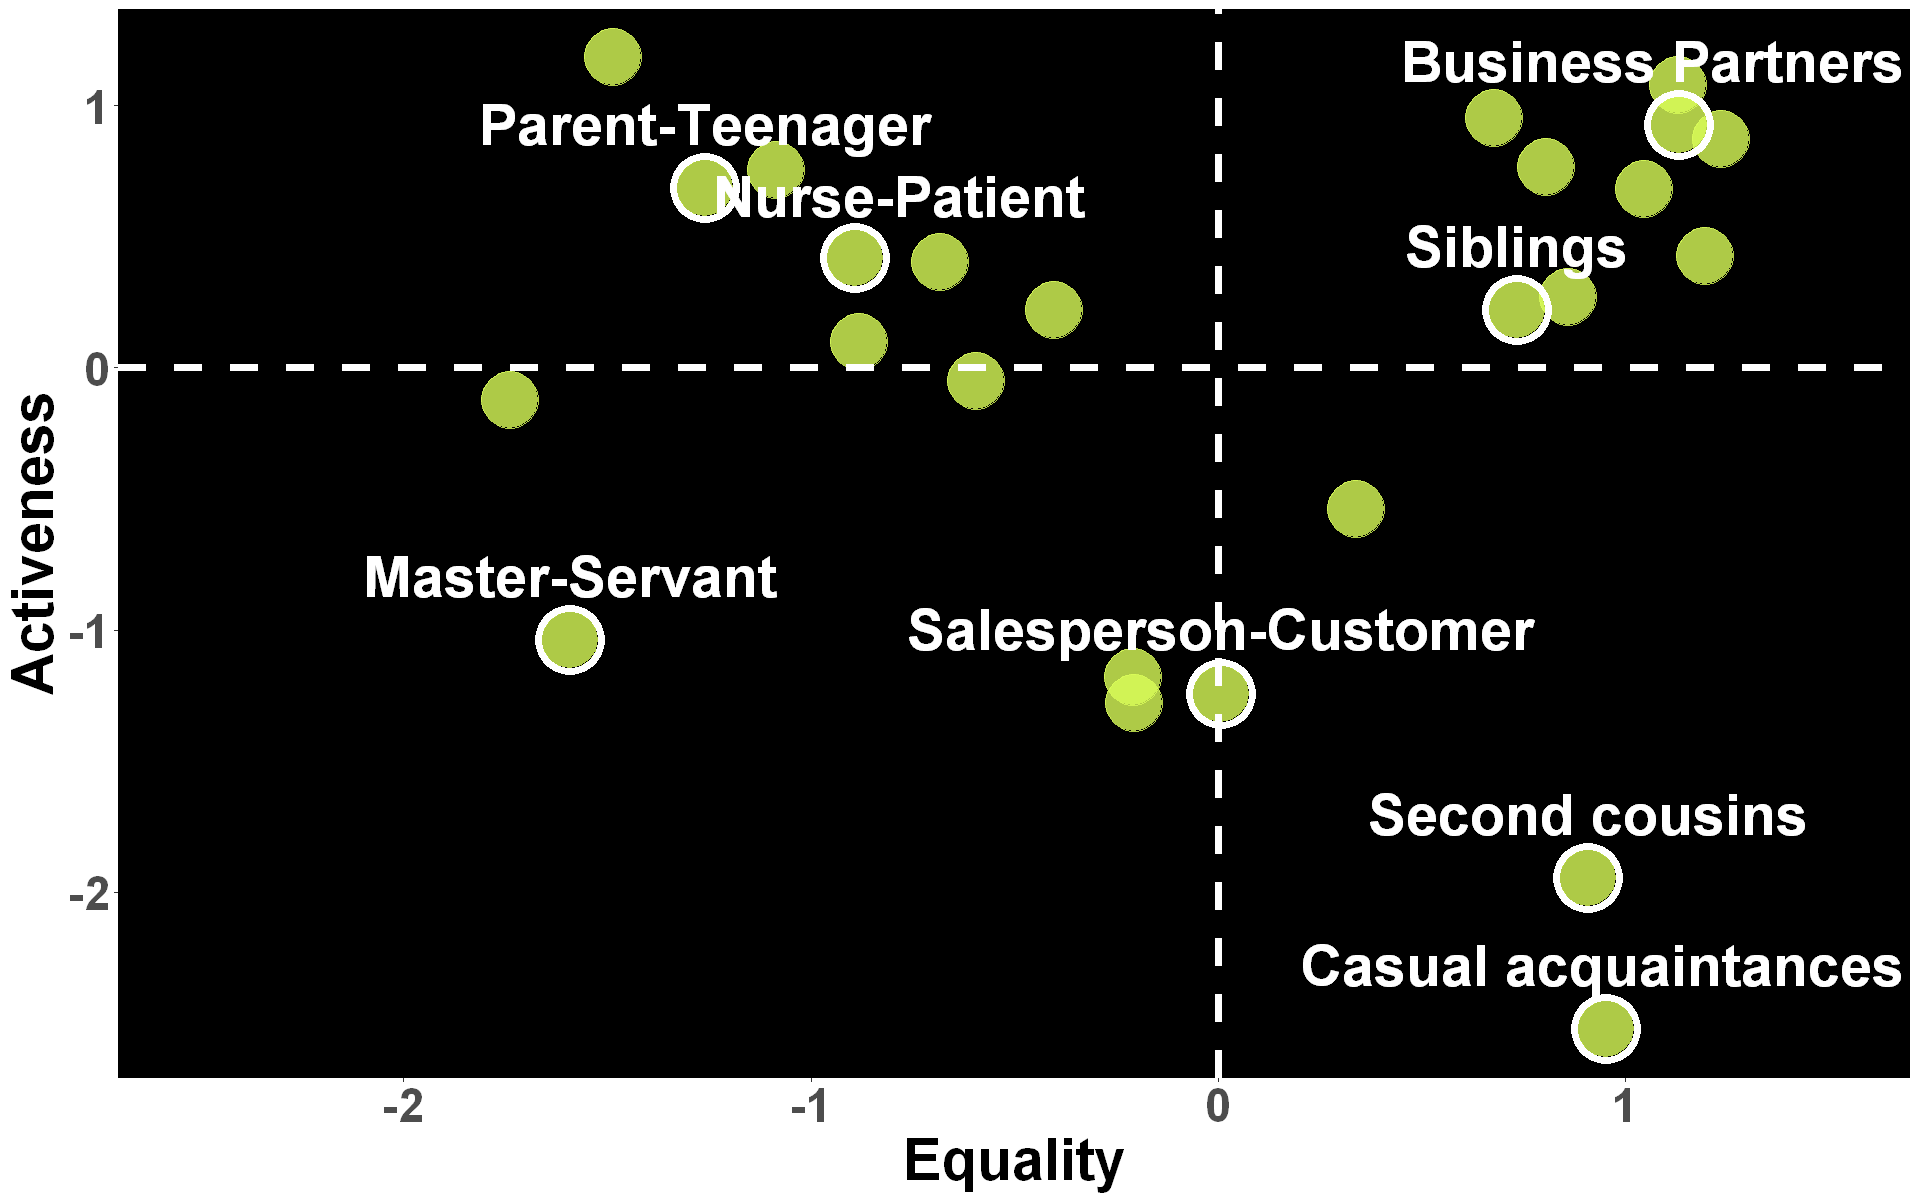

In [21]:
rels_shown = c('Parent-Teenager','Siblings','Salesperson-Customer','Second cousins','Master-Servant',
              'Business Partners','Casual acquaintances','Nurse-Patient')
rels_shown_plot = scores_var_plot %>% filter(rel%in%rels_shown)

options(repr.plot.height=10,repr.plot.width=16)
ggplot(scores_var_plot, aes(x=Equality,y=Activeness))+
geom_point(color='#DAFD59',size=16,alpha=0.8)+

geom_text_repel(data = rels_shown_plot,
                mapping=aes(label=rownames(rels_shown_plot)),size=12,
                seed = randomseed,nudge_y=0.25,
                fontface = 'bold',color='white',
                #family='',
                min.segment.length = Inf)+
geom_point(data = rels_shown_plot,color='white',size=16,shape=1,stroke=3)+

xlim(-2.5,1.5)+
xlab('Equality')+
ylab('Activeness')+

geom_hline(yintercept = 0,linetype='dashed',size = 2,color='white')+
geom_vline(xintercept = 0,linetype='dashed',size = 2,color='white')+

theme_bw()+
theme(panel.border=element_blank(),panel.grid=element_blank(),
      panel.background = element_rect(fill = 'black'), 
      axis.title=element_text(size=35,face='bold'),
      axis.text=element_text(size=28,face='bold'),
      legend.title=element_text(face="bold",size=30),
      legend.position='top',#legend.key.height=unit(1,'cm')
      legend.text=element_text(face="bold",size=20))

## 5d solution

In [15]:
dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 5

loadings_none = dim_rel.pca$rotation[,1:ncomp]
scores_none = dim_rel.pca$x[,1:ncomp] 

rawLoadings = loadings_none %*% diag(dim_rel.pca$sdev,ncomp,ncomp)
loadings_var = varimax(rawLoadings)$loadings
scores_var = scale(scores_none) %*% varimax(rawLoadings)$rotmat

write.csv(loadings_var,'output_data/pca_results/wish_replication/loadings_var_5c.csv')
scores_var = as.data.frame(scores_var)
write.csv(scores_var,'output_data/pca_results/wish_replication/scores_var_5c.csv')

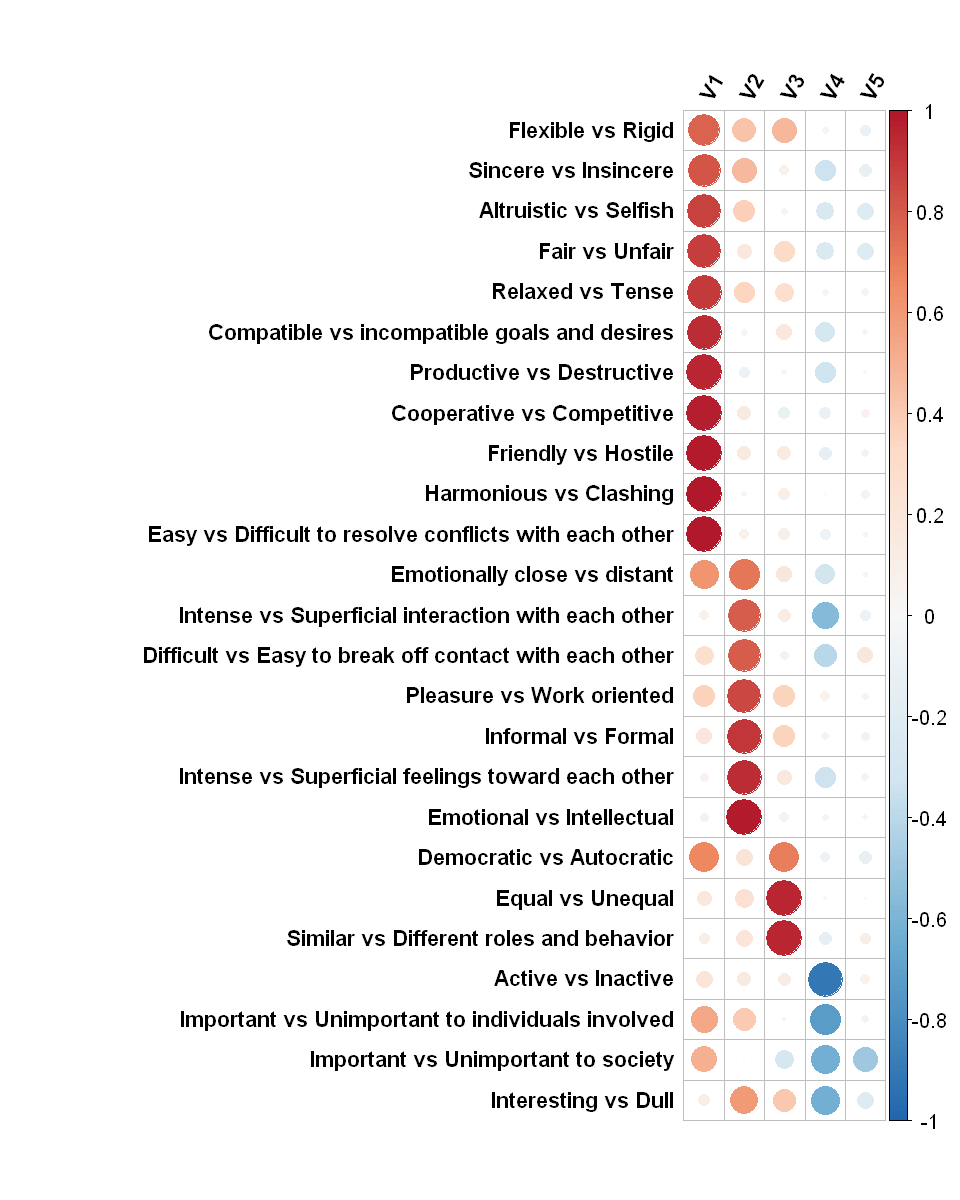

In [17]:
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:25)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:5)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
loadings_var_reorder['rel'] = rownames(loadings_var_reorder)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(V1)
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(V2)
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(V3)
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(V4)
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(V5)
rownames(loadings_var_reorder) = loadings_var_reorder$'rel'

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

options(repr.plot.width=8, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))